In [1]:
from tensorflow import keras
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import sklearn.metrics
import h5py
import pandas as pd
import os
import os.path
import sys
import h5py
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model


2022-12-20 07:14:35.551047: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 07:14:35.621292: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
TARGET_BYTE = 0 #何バイト目を攻撃するか決める

In [3]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [4]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [5]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [6]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [7]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,170:220]
test_trace2 = test_trace[:,170:220]
attack_trace2 = attack_trace[:,170:220]
train_trace.shape

(80000, 1100)

In [8]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [9]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [10]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [11]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [12]:
print('train_trace shape:{}'.format(train_trace.shape))
print('train_sbox_out_hw shape:{}'.format(train_sbox_out_hw.shape))
print('test_trace shape:{}'.format(test_trace.shape))
print('test_sbox_out_hw shape:{}'.format(test_sbox_out_hw.shape))
print('attack_trace shape:{}'.format(attack_trace.shape))

print('train_trace type:{}'.format(type(train_trace)))
print('train_sbox_out_hw type:{}'.format(type(train_sbox_out_hw)))
print('test_trace type:{}'.format(type(test_trace)))
print('test_sbox_out_hw type:{}'.format(type(test_sbox_out_hw)))
print('attack_trace type:{}'.format(type(attack_trace)))

train_trace shape:(80000, 1100)
train_sbox_out_hw shape:(80000,)
test_trace shape:(20000, 1100)
test_sbox_out_hw shape:(20000,)
attack_trace shape:(1000, 1100)
train_trace type:<class 'numpy.ndarray'>
train_sbox_out_hw type:<class 'numpy.ndarray'>
test_trace type:<class 'numpy.ndarray'>
test_sbox_out_hw type:<class 'numpy.ndarray'>
attack_trace type:<class 'numpy.ndarray'>


In [13]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [14]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

2022-12-20 07:14:43.292723: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 07:14:43.294096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 07:14:43.294171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 07:14:43.294443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [15]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50


2022-12-20 07:14:44.414338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-20 07:14:45.148699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-12-20 07:14:45.149681: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f67d4154f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-20 07:14:45.149698: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2022-12-20 07:14:45.152153: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-20 07:14:45.219271: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of 

625/625 [==============================] - 6s 7ms/step - loss: 1.1871 - accuracy: 0.4978 - val_loss: 1.0173 - val_accuracy: 0.5617
Epoch 2/50
625/625 [==============================] - 4s 7ms/step - loss: 0.9645 - accuracy: 0.5865 - val_loss: 0.8900 - val_accuracy: 0.6270
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8619 - accuracy: 0.6346 - val_loss: 0.8265 - val_accuracy: 0.6546
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 0.7773 - accuracy: 0.6761 - val_loss: 0.7365 - val_accuracy: 0.6972
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7097 - accuracy: 0.7099 - val_loss: 0.6806 - val_accuracy: 0.7251
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.6528 - accuracy: 0.7372 - val_loss: 0.6292 - val_accuracy: 0.7462
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 0.6068 - accuracy: 0.7592 - val_loss: 0.5892 - val_accuracy: 0.7670
Epoch 8/50
625/62

In [16]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

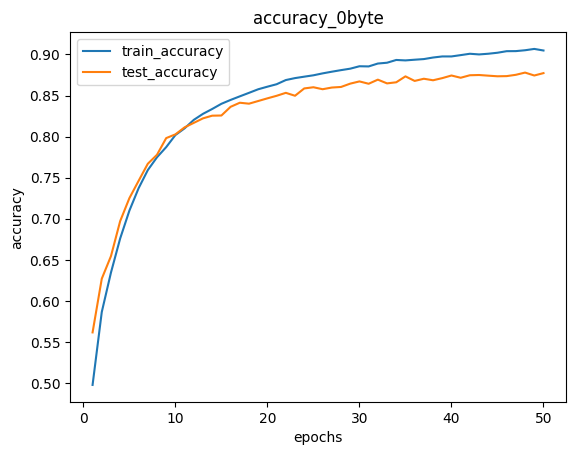

In [17]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [18]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 712us/step


(1000, 9)

In [19]:
attack_plain=data_attack['plain']

In [20]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [21]:
attack_sbox_out_hw.shape

(256, 1000)

In [22]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

28
13
5
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


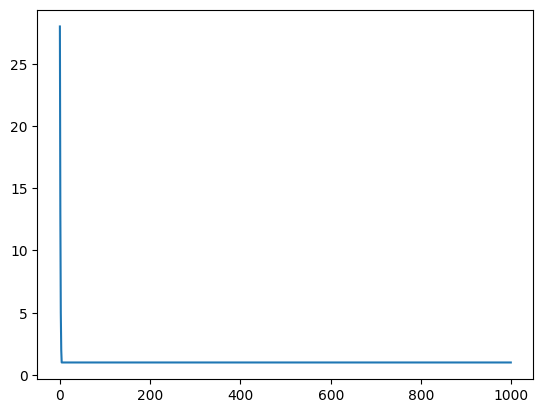

In [23]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

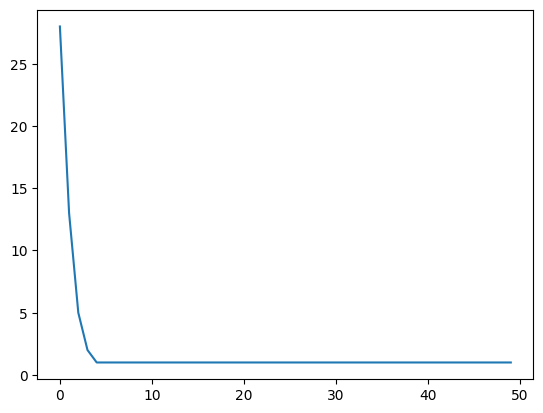

In [24]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [25]:
recovered_key0=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count0 = 1
        else:
            count0 = 0
        
        recovered_key0.append(count0) #攻撃成功バイト数の保存

recovered_key0 = np.array(recovered_key0)
np.save('./'+out+'/test0.npy', recovered_key0)

In [26]:
TARGET_BYTE = 1 #何バイト目を攻撃するか決める

In [27]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [28]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [29]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [30]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [31]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,410:460]
test_trace2 = test_trace[:,410:460]
attack_trace2 = attack_trace[:,410:460]
train_trace.shape

(80000, 1100)

In [32]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [33]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [34]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [35]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [36]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [37]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [38]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 5s 7ms/step - loss: 1.0820 - accuracy: 0.5445 - val_loss: 0.9181 - val_accuracy: 0.6072
Epoch 2/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8829 - accuracy: 0.6244 - val_loss: 0.8184 - val_accuracy: 0.6521
Epoch 3/50
625/625 [==============================] - 4s 7ms/step - loss: 0.7947 - accuracy: 0.6666 - val_loss: 0.7512 - val_accuracy: 0.6837
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7253 - accuracy: 0.6996 - val_loss: 0.6855 - val_accuracy: 0.7192
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.6669 - accuracy: 0.7291 - val_loss: 0.6440 - val_accuracy: 0.7402
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.6226 - accuracy: 0.7499 - val_loss: 0.6047 - val_accuracy: 0.7534
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.5890 - accuracy: 0.7658 - val_loss: 0.5802 - val_accuracy: 0.7660
Epoch 

In [39]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

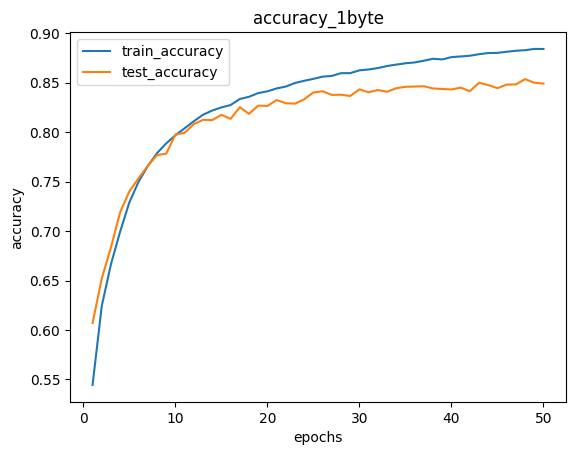

In [40]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [41]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 489us/step


(1000, 9)

In [42]:
attack_plain=data_attack['plain']

In [43]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [44]:
attack_sbox_out_hw.shape

(256, 1000)

In [45]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

56
20
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


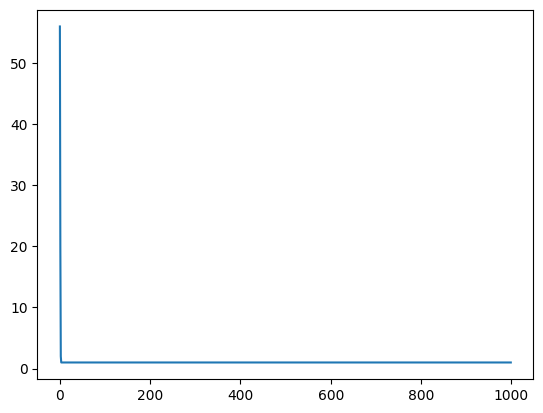

In [46]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

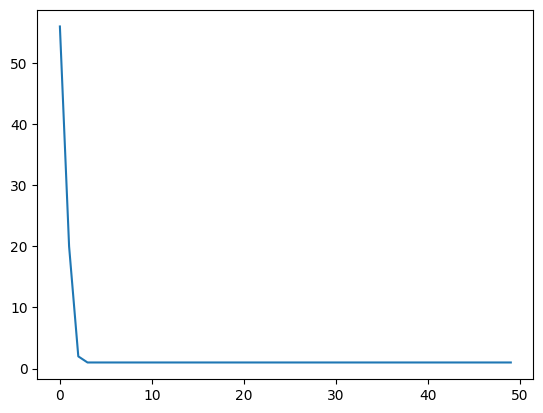

In [47]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [48]:
recovered_key1=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count1 = 1
        else:
            count1 = 0
        
        recovered_key1.append(count1) #攻撃成功バイト数の保存

recovered_key1 = np.array(recovered_key1)
np.save('./'+out+'/test1.npy', recovered_key1)

In [49]:
TARGET_BYTE = 2 #何バイト目を攻撃するか決める

In [50]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [51]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [52]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [53]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [54]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,680:730]
test_trace2 = test_trace[:,680:730]
attack_trace2 = attack_trace[:,680:730]
train_trace.shape

(80000, 1100)

In [55]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [56]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [57]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [58]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [59]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [60]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [61]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 4s 6ms/step - loss: 1.1883 - accuracy: 0.4894 - val_loss: 1.0660 - val_accuracy: 0.5386
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0623 - accuracy: 0.5350 - val_loss: 1.0189 - val_accuracy: 0.5524
Epoch 3/50
625/625 [==============================] - 4s 7ms/step - loss: 1.0146 - accuracy: 0.5569 - val_loss: 0.9824 - val_accuracy: 0.5773
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9756 - accuracy: 0.5749 - val_loss: 0.9564 - val_accuracy: 0.5846
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9466 - accuracy: 0.5900 - val_loss: 0.9307 - val_accuracy: 0.5976
Epoch 6/50
625/625 [==============================] - 4s 7ms/step - loss: 0.9205 - accuracy: 0.6024 - val_loss: 0.9200 - val_accuracy: 0.5989
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 0.9021 - accuracy: 0.6130 - val_loss: 0.8905 - val_accuracy: 0.6119
Epoch 

In [62]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

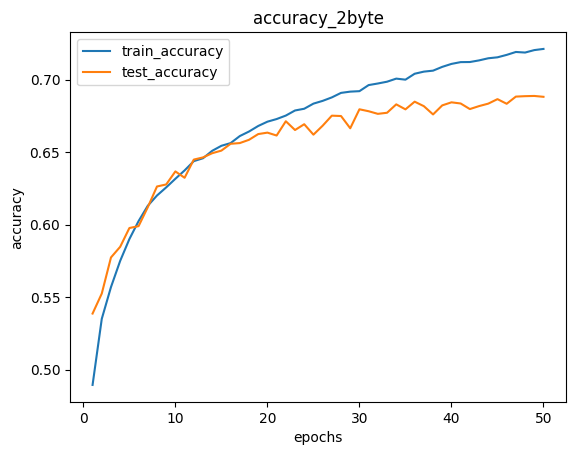

In [63]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [64]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 562us/step


(1000, 9)

In [65]:
attack_plain=data_attack['plain']

In [66]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [67]:
attack_sbox_out_hw.shape

(256, 1000)

In [68]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

56
15
7
4
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


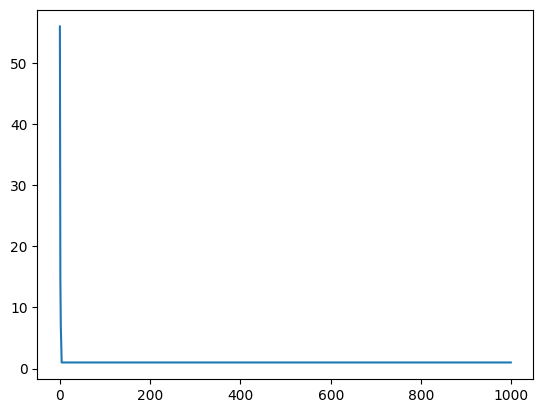

In [69]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

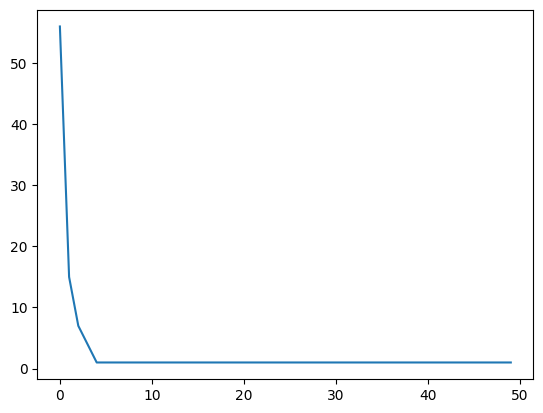

In [70]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [71]:
recovered_key2=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count2 = 1
        else:
            count2 = 0
        
        recovered_key2.append(count2) #攻撃成功バイト数の保存

recovered_key2 = np.array(recovered_key2)
np.save('./'+out+'/test2.npy', recovered_key2)

In [72]:
TARGET_BYTE = 3 #何バイト目を攻撃するか決める

In [73]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [74]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [75]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [76]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [77]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,920:970]
test_trace2 = test_trace[:,920:970]
attack_trace2 = attack_trace[:,920:970]
train_trace.shape

(80000, 1100)

In [78]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [79]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [80]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [81]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [82]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [83]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [84]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 5s 6ms/step - loss: 1.1021 - accuracy: 0.5320 - val_loss: 0.9534 - val_accuracy: 0.5940
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9293 - accuracy: 0.6009 - val_loss: 0.8821 - val_accuracy: 0.6210
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8619 - accuracy: 0.6323 - val_loss: 0.8140 - val_accuracy: 0.6594
Epoch 4/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8106 - accuracy: 0.6576 - val_loss: 0.7813 - val_accuracy: 0.6715
Epoch 5/50
625/625 [==============================] - 4s 7ms/step - loss: 0.7680 - accuracy: 0.6777 - val_loss: 0.7379 - val_accuracy: 0.6935
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7346 - accuracy: 0.6937 - val_loss: 0.7193 - val_accuracy: 0.7017
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 0.7082 - accuracy: 0.7063 - val_loss: 0.6840 - val_accuracy: 0.7206
Epoch 

In [85]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

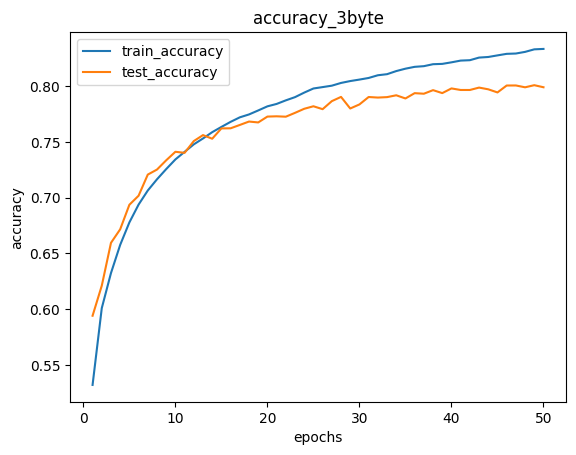

In [86]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [87]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 529us/step


(1000, 9)

In [88]:
attack_plain=data_attack['plain']

In [89]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [90]:
attack_sbox_out_hw.shape

(256, 1000)

In [91]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

28
19
8
4
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


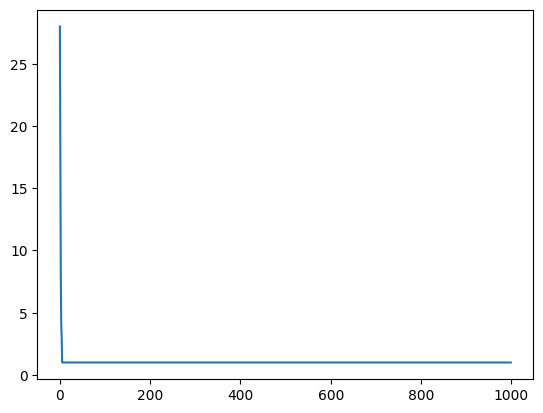

In [92]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

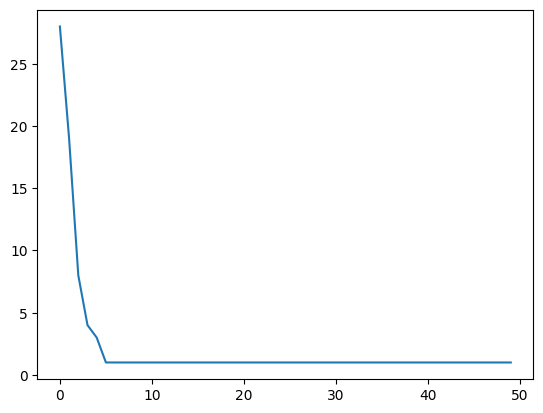

In [93]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [94]:
recovered_key3=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count3 = 1
        else:
            count3 = 0
        
        recovered_key3.append(count3) #攻撃成功バイト数の保存

recovered_key3 = np.array(recovered_key3)
np.save('./'+out+'/test3.npy', recovered_key3)

In [95]:
TARGET_BYTE = 4 #何バイト目を攻撃するか決める

In [96]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [97]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [98]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [99]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [100]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,220:270]
test_trace2 = test_trace[:,220:270]
attack_trace2 = attack_trace[:,220:270]
train_trace.shape

(80000, 1100)

In [101]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [102]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [103]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [104]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [105]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [106]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [107]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 4s 6ms/step - loss: 1.1218 - accuracy: 0.5252 - val_loss: 0.9834 - val_accuracy: 0.5748
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9386 - accuracy: 0.6016 - val_loss: 0.8875 - val_accuracy: 0.6260
Epoch 3/50
625/625 [==============================] - 3s 5ms/step - loss: 0.8535 - accuracy: 0.6409 - val_loss: 0.8115 - val_accuracy: 0.6589
Epoch 4/50
625/625 [==============================] - 4s 7ms/step - loss: 0.7898 - accuracy: 0.6697 - val_loss: 0.7660 - val_accuracy: 0.6802
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 0.7411 - accuracy: 0.6940 - val_loss: 0.7379 - val_accuracy: 0.6924
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7023 - accuracy: 0.7117 - val_loss: 0.6911 - val_accuracy: 0.7120
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 0.6702 - accuracy: 0.7261 - val_loss: 0.6701 - val_accuracy: 0.7235
Epoch 

In [108]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

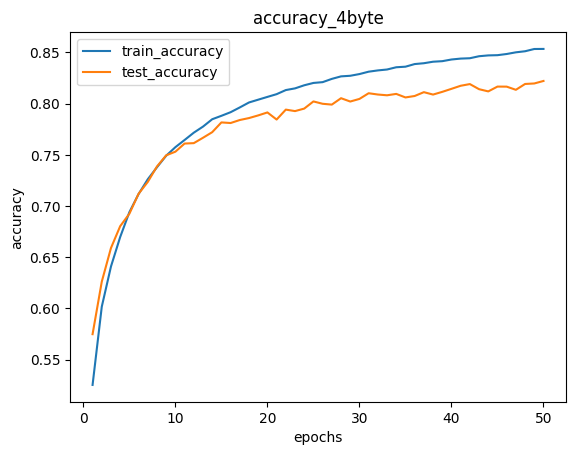

In [109]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [110]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 601us/step


(1000, 9)

In [111]:
attack_plain=data_attack['plain']

In [112]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [113]:
attack_sbox_out_hw.shape

(256, 1000)

In [114]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

56
5
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

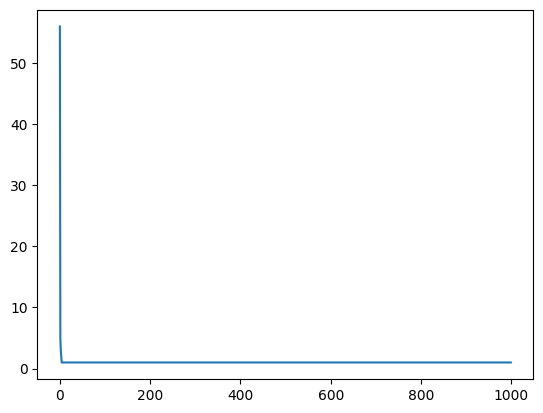

In [115]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

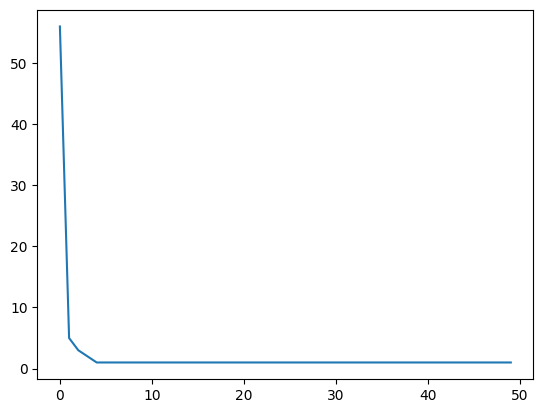

In [116]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [117]:
recovered_key4=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count4 = 1
        else:
            count4 = 0
        
        recovered_key4.append(count4) #攻撃成功バイト数の保存

recovered_key4 = np.array(recovered_key4)
np.save('./'+out+'/test4.npy', recovered_key4)

In [118]:
TARGET_BYTE = 5 #何バイト目を攻撃するか決める

In [119]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [120]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [121]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [122]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [123]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,480:530]
test_trace2 = test_trace[:,480:530]
attack_trace2 = attack_trace[:,480:530]
train_trace.shape

(80000, 1100)

In [124]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [125]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [126]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [127]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [128]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [129]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [130]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 5s 6ms/step - loss: 1.1273 - accuracy: 0.5171 - val_loss: 1.0163 - val_accuracy: 0.5512
Epoch 2/50
625/625 [==============================] - 4s 7ms/step - loss: 0.9944 - accuracy: 0.5647 - val_loss: 0.9578 - val_accuracy: 0.5789
Epoch 3/50
625/625 [==============================] - 4s 7ms/step - loss: 0.9492 - accuracy: 0.5847 - val_loss: 0.9149 - val_accuracy: 0.5994
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9105 - accuracy: 0.6046 - val_loss: 0.8869 - val_accuracy: 0.6072
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8774 - accuracy: 0.6208 - val_loss: 0.8536 - val_accuracy: 0.6288
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8492 - accuracy: 0.6328 - val_loss: 0.8405 - val_accuracy: 0.6372
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8274 - accuracy: 0.6439 - val_loss: 0.8122 - val_accuracy: 0.6503
Epoch 

In [131]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

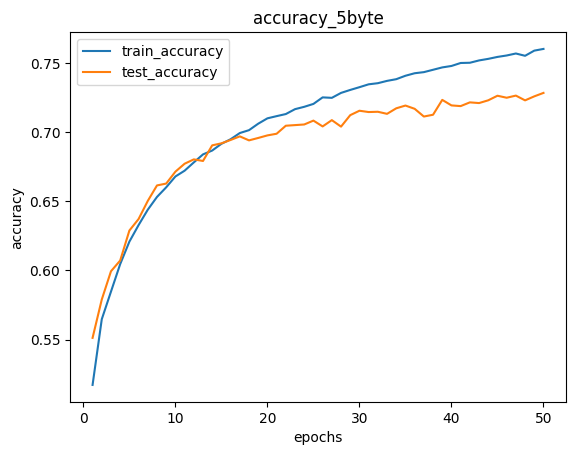

In [132]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [133]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 492us/step


(1000, 9)

In [134]:
attack_plain=data_attack['plain']

In [135]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [136]:
attack_sbox_out_hw.shape

(256, 1000)

In [137]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

56
27
11
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

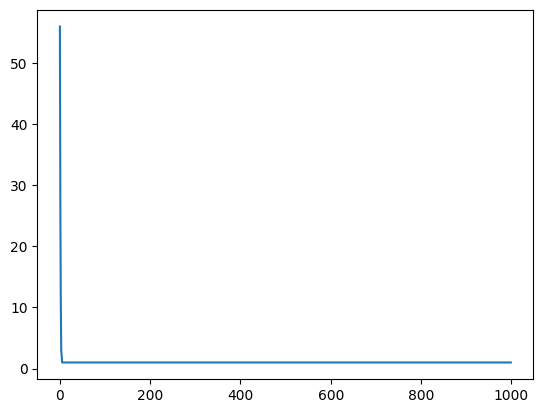

In [138]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

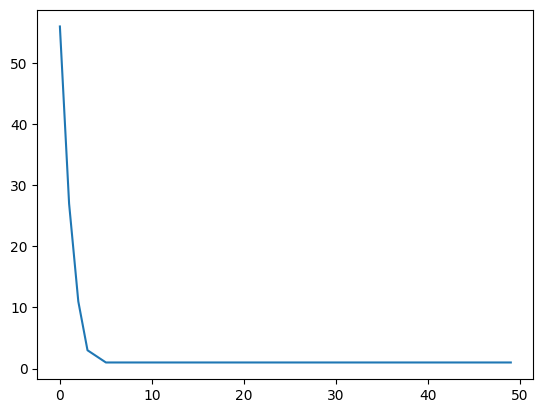

In [139]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [140]:
recovered_key5=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count5 = 1
        else:
            count5 = 0
        
        recovered_key5.append(count5) #攻撃成功バイト数の保存

recovered_key5 = np.array(recovered_key5)
np.save('./'+out+'/test5.npy', recovered_key5)

In [141]:
TARGET_BYTE = 6 #何バイト目を攻撃するか決める

In [142]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [143]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [144]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [145]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [146]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,740:790]
test_trace2 = test_trace[:,740:790]
attack_trace2 = attack_trace[:,740:790]
train_trace.shape

(80000, 1100)

In [147]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [148]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [149]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [150]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [151]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [152]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [153]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 5s 6ms/step - loss: 1.2389 - accuracy: 0.4687 - val_loss: 1.1005 - val_accuracy: 0.5203
Epoch 2/50
625/625 [==============================] - 4s 7ms/step - loss: 1.1015 - accuracy: 0.5165 - val_loss: 1.0606 - val_accuracy: 0.5289
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0689 - accuracy: 0.5312 - val_loss: 1.0427 - val_accuracy: 0.5409
Epoch 4/50
625/625 [==============================] - 4s 7ms/step - loss: 1.0432 - accuracy: 0.5419 - val_loss: 1.0200 - val_accuracy: 0.5448
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0236 - accuracy: 0.5494 - val_loss: 0.9969 - val_accuracy: 0.5597
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0059 - accuracy: 0.5584 - val_loss: 0.9823 - val_accuracy: 0.5598
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9930 - accuracy: 0.5646 - val_loss: 0.9833 - val_accuracy: 0.5609
Epoch 

In [154]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

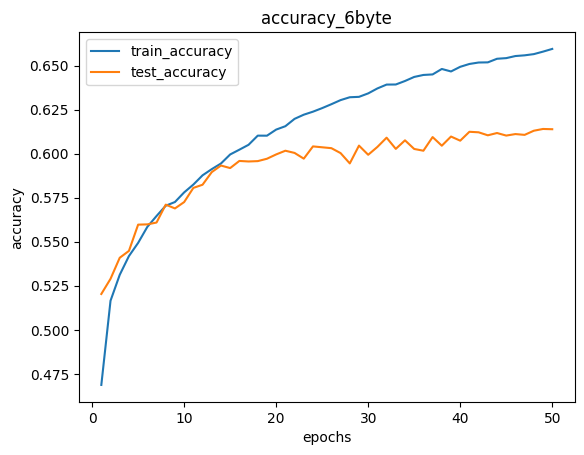

In [155]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [156]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 517us/step


(1000, 9)

In [157]:
attack_plain=data_attack['plain']

In [158]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [159]:
attack_sbox_out_hw.shape

(256, 1000)

In [160]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

126
58
18
4
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


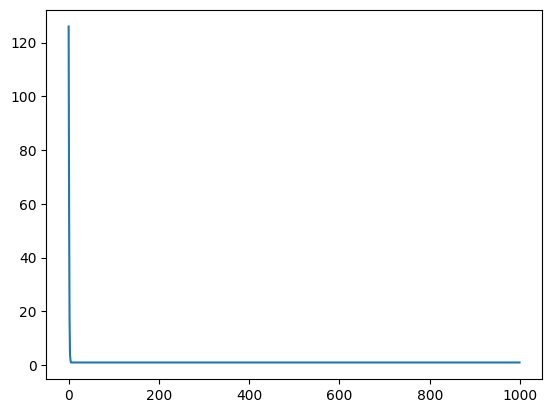

In [161]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

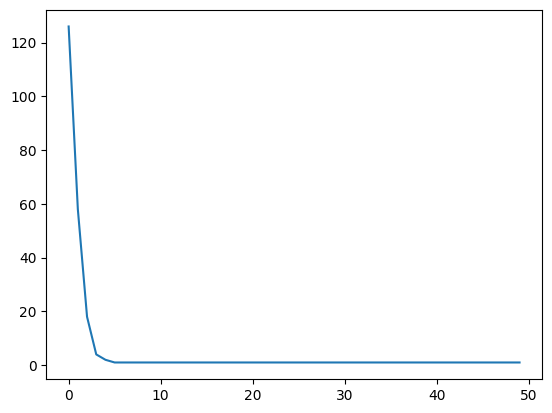

In [162]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [163]:
recovered_key6=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count6 = 1
        else:
            count6 = 0
        
        recovered_key6.append(count6) #攻撃成功バイト数の保存

recovered_key6 = np.array(recovered_key6)
np.save('./'+out+'/test6.npy', recovered_key6)

In [164]:
TARGET_BYTE = 7 #何バイト目を攻撃するか決める

In [165]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [166]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [167]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [168]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [169]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,980:1030]
test_trace2 = test_trace[:,980:1030]
attack_trace2 = attack_trace[:,980:1030]
train_trace.shape

(80000, 1100)

In [170]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [171]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [172]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [173]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [174]:
print('train_trace shape:{}'.format(train_trace.shape))
print('train_sbox_out_hw shape:{}'.format(train_sbox_out_hw.shape))
print('test_trace shape:{}'.format(test_trace.shape))
print('test_sbox_out_hw shape:{}'.format(test_sbox_out_hw.shape))
print('attack_trace shape:{}'.format(attack_trace.shape))

print('train_trace type:{}'.format(type(train_trace)))
print('train_sbox_out_hw type:{}'.format(type(train_sbox_out_hw)))
print('test_trace type:{}'.format(type(test_trace)))
print('test_sbox_out_hw type:{}'.format(type(test_sbox_out_hw)))
print('attack_trace type:{}'.format(type(attack_trace)))

train_trace shape:(80000, 1100)
train_sbox_out_hw shape:(80000,)
test_trace shape:(20000, 1100)
test_sbox_out_hw shape:(20000,)
attack_trace shape:(1000, 1100)
train_trace type:<class 'numpy.ndarray'>
train_sbox_out_hw type:<class 'numpy.ndarray'>
test_trace type:<class 'numpy.ndarray'>
test_sbox_out_hw type:<class 'numpy.ndarray'>
attack_trace type:<class 'numpy.ndarray'>


In [175]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [176]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [177]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 5s 7ms/step - loss: 1.1278 - accuracy: 0.5185 - val_loss: 0.9949 - val_accuracy: 0.5635
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9772 - accuracy: 0.5757 - val_loss: 0.9192 - val_accuracy: 0.6043
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9211 - accuracy: 0.6018 - val_loss: 0.8749 - val_accuracy: 0.6178
Epoch 4/50
625/625 [==============================] - 3s 6ms/step - loss: 0.8746 - accuracy: 0.6245 - val_loss: 0.8307 - val_accuracy: 0.6424
Epoch 5/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8374 - accuracy: 0.6420 - val_loss: 0.7908 - val_accuracy: 0.6611
Epoch 6/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8025 - accuracy: 0.6594 - val_loss: 0.7781 - val_accuracy: 0.6690
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 0.7744 - accuracy: 0.6751 - val_loss: 0.7455 - val_accuracy: 0.6835
Epoch 

In [178]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

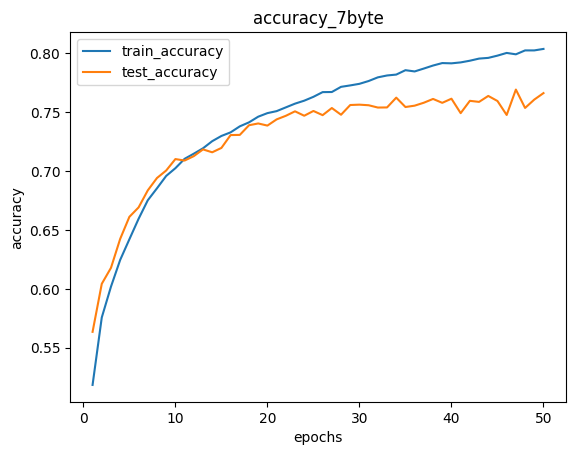

In [179]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [180]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 488us/step


(1000, 9)

In [181]:
attack_plain=data_attack['plain']

In [182]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [183]:
attack_sbox_out_hw.shape

(256, 1000)

In [184]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

70
31
18
5
2
2
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

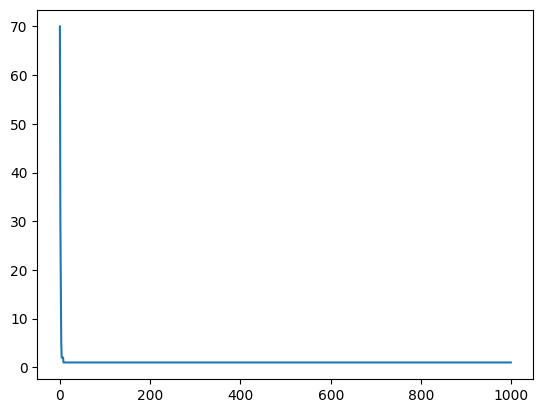

In [185]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

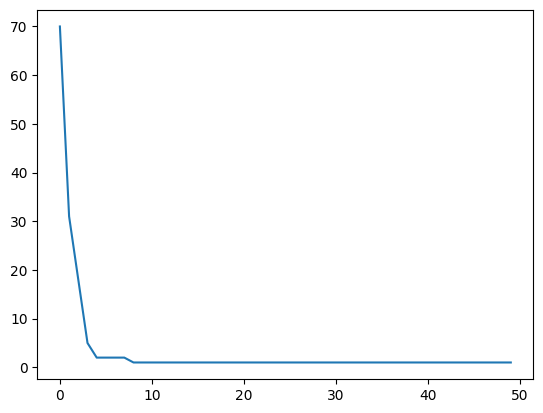

In [186]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [187]:
recovered_key7=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count7 = 1
        else:
            count7 = 0
        
        recovered_key7.append(count7) #攻撃成功バイト数の保存

recovered_key7 = np.array(recovered_key7)
np.save('./'+out+'/test7.npy', recovered_key7)

In [188]:
TARGET_BYTE = 8 #何バイト目を攻撃するか決める

In [189]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [190]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [191]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [192]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [193]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,290:340]
test_trace2 = test_trace[:,290:340]
attack_trace2 = attack_trace[:,290:340]
train_trace.shape

(80000, 1100)

In [194]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [195]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [196]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [197]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [198]:
print('train_trace shape:{}'.format(train_trace.shape))
print('train_sbox_out_hw shape:{}'.format(train_sbox_out_hw.shape))
print('test_trace shape:{}'.format(test_trace.shape))
print('test_sbox_out_hw shape:{}'.format(test_sbox_out_hw.shape))
print('attack_trace shape:{}'.format(attack_trace.shape))

print('train_trace type:{}'.format(type(train_trace)))
print('train_sbox_out_hw type:{}'.format(type(train_sbox_out_hw)))
print('test_trace type:{}'.format(type(test_trace)))
print('test_sbox_out_hw type:{}'.format(type(test_sbox_out_hw)))
print('attack_trace type:{}'.format(type(attack_trace)))

train_trace shape:(80000, 1100)
train_sbox_out_hw shape:(80000,)
test_trace shape:(20000, 1100)
test_sbox_out_hw shape:(20000,)
attack_trace shape:(1000, 1100)
train_trace type:<class 'numpy.ndarray'>
train_sbox_out_hw type:<class 'numpy.ndarray'>
test_trace type:<class 'numpy.ndarray'>
test_sbox_out_hw type:<class 'numpy.ndarray'>
attack_trace type:<class 'numpy.ndarray'>


In [199]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [200]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [201]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 5s 6ms/step - loss: 1.2098 - accuracy: 0.4799 - val_loss: 1.1100 - val_accuracy: 0.5141
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0908 - accuracy: 0.5174 - val_loss: 1.0744 - val_accuracy: 0.5239
Epoch 3/50
625/625 [==============================] - 4s 7ms/step - loss: 1.0606 - accuracy: 0.5300 - val_loss: 1.0402 - val_accuracy: 0.5390
Epoch 4/50
625/625 [==============================] - 4s 7ms/step - loss: 1.0376 - accuracy: 0.5422 - val_loss: 1.0224 - val_accuracy: 0.5462
Epoch 5/50
625/625 [==============================] - 4s 7ms/step - loss: 1.0181 - accuracy: 0.5488 - val_loss: 1.0022 - val_accuracy: 0.5577
Epoch 6/50
625/625 [==============================] - 4s 7ms/step - loss: 1.0027 - accuracy: 0.5555 - val_loss: 0.9991 - val_accuracy: 0.5599
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 0.9875 - accuracy: 0.5660 - val_loss: 0.9800 - val_accuracy: 0.5684
Epoch 

In [202]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

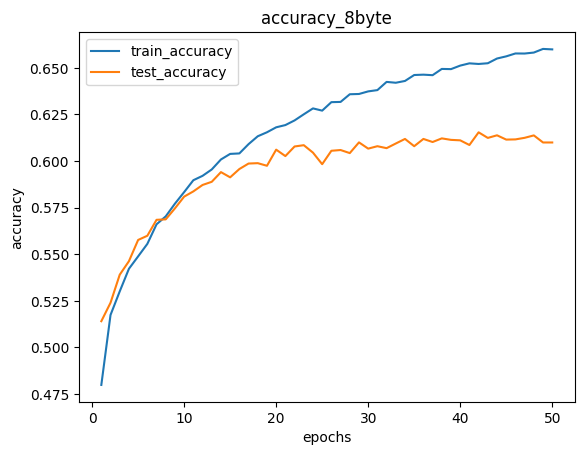

In [203]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [204]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 598us/step


(1000, 9)

In [205]:
attack_plain=data_attack['plain']

In [206]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [207]:
attack_sbox_out_hw.shape

(256, 1000)

In [208]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

56
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

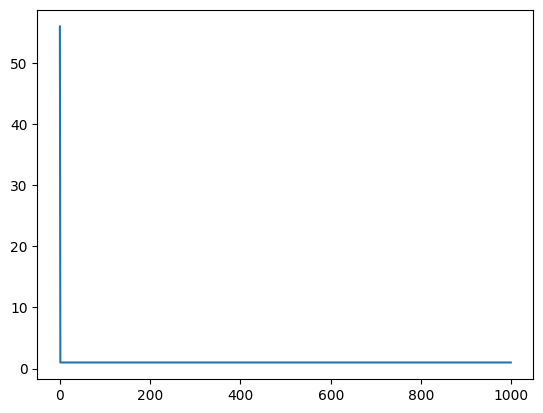

In [209]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

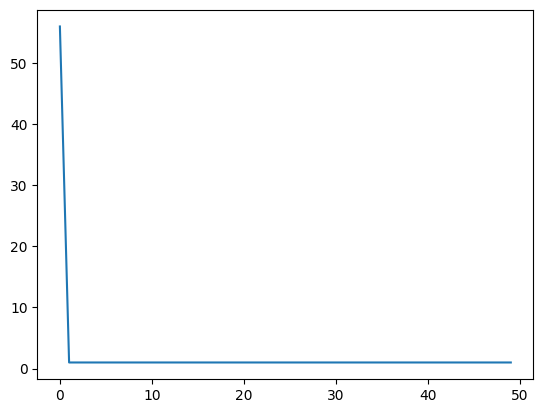

In [210]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [211]:
recovered_key8=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count8 = 1
        else:
            count8 = 0
        
        recovered_key8.append(count8) #攻撃成功バイト数の保存

recovered_key8 = np.array(recovered_key8)
np.save('./'+out+'/test8.npy', recovered_key8)

In [212]:
TARGET_BYTE = 9 #何バイト目を攻撃するか決める

In [213]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [214]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [215]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [216]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [217]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,530:580]
test_trace2 = test_trace[:,530:580]
attack_trace2 = attack_trace[:,530:580]
train_trace.shape

(80000, 1100)

In [218]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [219]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [220]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [221]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [222]:
print('train_trace shape:{}'.format(train_trace.shape))
print('train_sbox_out_hw shape:{}'.format(train_sbox_out_hw.shape))
print('test_trace shape:{}'.format(test_trace.shape))
print('test_sbox_out_hw shape:{}'.format(test_sbox_out_hw.shape))
print('attack_trace shape:{}'.format(attack_trace.shape))

print('train_trace type:{}'.format(type(train_trace)))
print('train_sbox_out_hw type:{}'.format(type(train_sbox_out_hw)))
print('test_trace type:{}'.format(type(test_trace)))
print('test_sbox_out_hw type:{}'.format(type(test_sbox_out_hw)))
print('attack_trace type:{}'.format(type(attack_trace)))

train_trace shape:(80000, 1100)
train_sbox_out_hw shape:(80000,)
test_trace shape:(20000, 1100)
test_sbox_out_hw shape:(20000,)
attack_trace shape:(1000, 1100)
train_trace type:<class 'numpy.ndarray'>
train_sbox_out_hw type:<class 'numpy.ndarray'>
test_trace type:<class 'numpy.ndarray'>
test_sbox_out_hw type:<class 'numpy.ndarray'>
attack_trace type:<class 'numpy.ndarray'>


In [223]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [224]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [225]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 4s 5ms/step - loss: 1.1194 - accuracy: 0.5212 - val_loss: 0.9776 - val_accuracy: 0.5774
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9574 - accuracy: 0.5818 - val_loss: 0.9304 - val_accuracy: 0.5950
Epoch 3/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8977 - accuracy: 0.6107 - val_loss: 0.8596 - val_accuracy: 0.6316
Epoch 4/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8456 - accuracy: 0.6379 - val_loss: 0.8186 - val_accuracy: 0.6511
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8060 - accuracy: 0.6576 - val_loss: 0.7817 - val_accuracy: 0.6704
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7750 - accuracy: 0.6725 - val_loss: 0.7704 - val_accuracy: 0.6812
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 0.7504 - accuracy: 0.6868 - val_loss: 0.7288 - val_accuracy: 0.6964
Epoch 

In [226]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

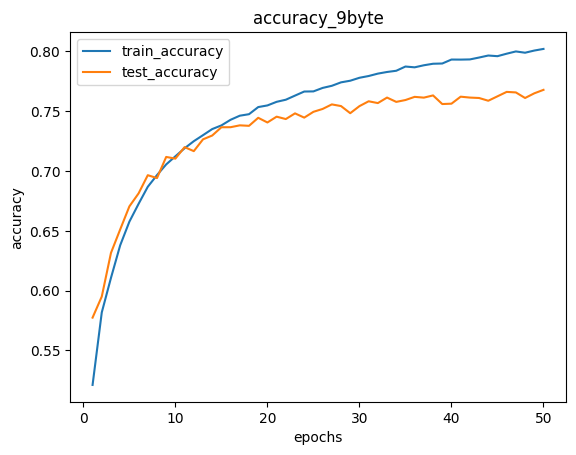

In [227]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [228]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 533us/step


(1000, 9)

In [229]:
attack_plain=data_attack['plain']

In [230]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [231]:
attack_sbox_out_hw.shape

(256, 1000)

In [232]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

70
36
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


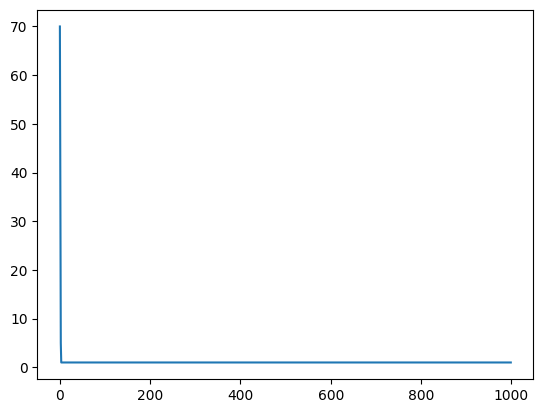

In [233]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

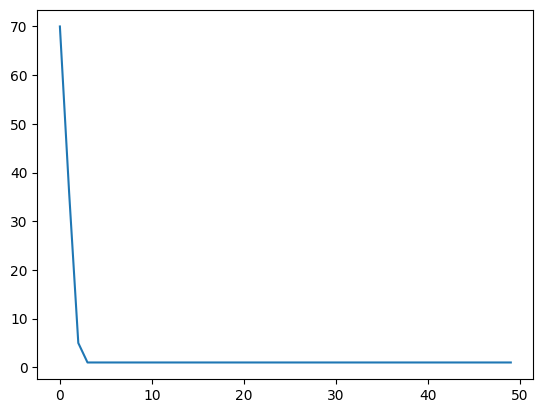

In [234]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [235]:
recovered_key9=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count9 = 1
        else:
            count9 = 0
        
        recovered_key9.append(count9) #攻撃成功バイト数の保存

recovered_key9 = np.array(recovered_key9)
np.save('./'+out+'/test9.npy', recovered_key9)

In [236]:
TARGET_BYTE = 10 #何バイト目を攻撃するか決める

In [237]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [238]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [239]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [240]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [241]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,790:840]
test_trace2 = test_trace[:,790:840]
attack_trace2 = attack_trace[:,790:840]
train_trace.shape

(80000, 1100)

In [242]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [243]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [244]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [245]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [246]:
print('train_trace shape:{}'.format(train_trace.shape))
print('train_sbox_out_hw shape:{}'.format(train_sbox_out_hw.shape))
print('test_trace shape:{}'.format(test_trace.shape))
print('test_sbox_out_hw shape:{}'.format(test_sbox_out_hw.shape))
print('attack_trace shape:{}'.format(attack_trace.shape))

print('train_trace type:{}'.format(type(train_trace)))
print('train_sbox_out_hw type:{}'.format(type(train_sbox_out_hw)))
print('test_trace type:{}'.format(type(test_trace)))
print('test_sbox_out_hw type:{}'.format(type(test_sbox_out_hw)))
print('attack_trace type:{}'.format(type(attack_trace)))

train_trace shape:(80000, 1100)
train_sbox_out_hw shape:(80000,)
test_trace shape:(20000, 1100)
test_sbox_out_hw shape:(20000,)
attack_trace shape:(1000, 1100)
train_trace type:<class 'numpy.ndarray'>
train_sbox_out_hw type:<class 'numpy.ndarray'>
test_trace type:<class 'numpy.ndarray'>
test_sbox_out_hw type:<class 'numpy.ndarray'>
attack_trace type:<class 'numpy.ndarray'>


In [247]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [248]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [249]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 5s 7ms/step - loss: 1.2012 - accuracy: 0.4859 - val_loss: 1.0852 - val_accuracy: 0.5205
Epoch 2/50
625/625 [==============================] - 4s 7ms/step - loss: 1.0563 - accuracy: 0.5378 - val_loss: 1.0111 - val_accuracy: 0.5566
Epoch 3/50
625/625 [==============================] - 4s 7ms/step - loss: 0.9972 - accuracy: 0.5659 - val_loss: 0.9603 - val_accuracy: 0.5810
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9585 - accuracy: 0.5842 - val_loss: 0.9308 - val_accuracy: 0.5974
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9287 - accuracy: 0.5997 - val_loss: 0.9059 - val_accuracy: 0.6086
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9061 - accuracy: 0.6111 - val_loss: 0.8876 - val_accuracy: 0.6204
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 0.8882 - accuracy: 0.6201 - val_loss: 0.8758 - val_accuracy: 0.6222
Epoch 

In [250]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

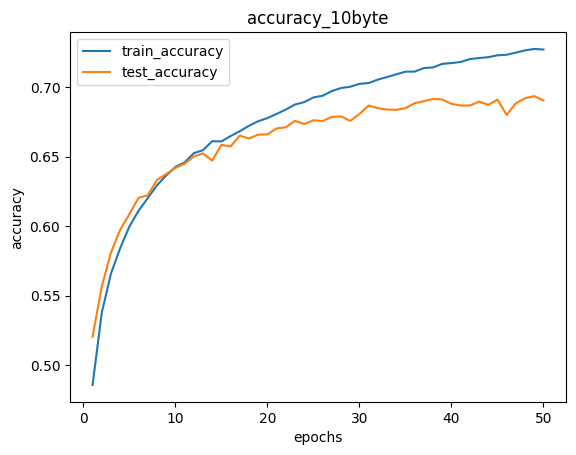

In [251]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [252]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 544us/step


(1000, 9)

In [253]:
attack_plain=data_attack['plain']

In [254]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [255]:
attack_sbox_out_hw.shape

(256, 1000)

In [256]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

84
25
8
5
3
3
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


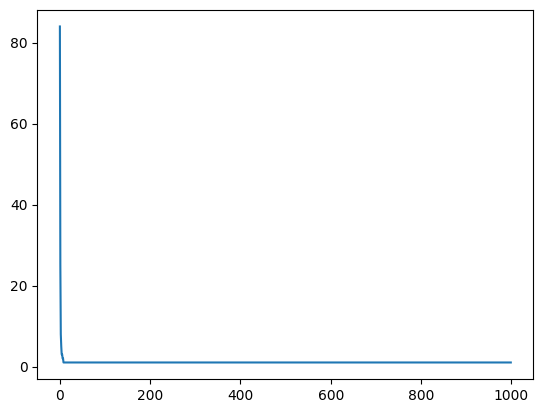

In [257]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

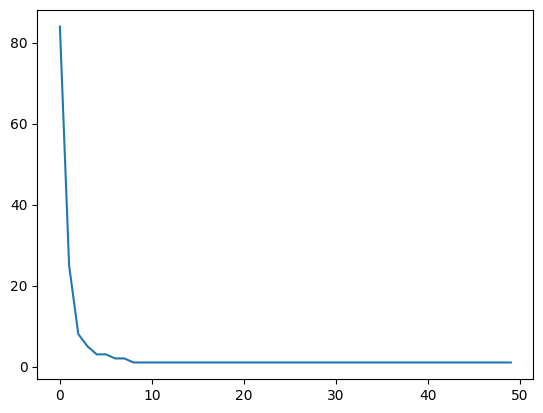

In [258]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [259]:
recovered_key10=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count10 = 1
        else:
            count10 = 0
        
        recovered_key10.append(count10) #攻撃成功バイト数の保存

recovered_key10 = np.array(recovered_key10)
np.save('./'+out+'/test10.npy', recovered_key10)

In [260]:
TARGET_BYTE = 11 #何バイト目を攻撃するか決める

In [261]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [262]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [263]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [264]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [265]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,1040:1090]
test_trace2 = test_trace[:,1040:1090]
attack_trace2 = attack_trace[:,1040:1090]
train_trace.shape

(80000, 1100)

In [266]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [267]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [268]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [269]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [270]:
print('train_trace shape:{}'.format(train_trace.shape))
print('train_sbox_out_hw shape:{}'.format(train_sbox_out_hw.shape))
print('test_trace shape:{}'.format(test_trace.shape))
print('test_sbox_out_hw shape:{}'.format(test_sbox_out_hw.shape))
print('attack_trace shape:{}'.format(attack_trace.shape))

print('train_trace type:{}'.format(type(train_trace)))
print('train_sbox_out_hw type:{}'.format(type(train_sbox_out_hw)))
print('test_trace type:{}'.format(type(test_trace)))
print('test_sbox_out_hw type:{}'.format(type(test_sbox_out_hw)))
print('attack_trace type:{}'.format(type(attack_trace)))

train_trace shape:(80000, 1100)
train_sbox_out_hw shape:(80000,)
test_trace shape:(20000, 1100)
test_sbox_out_hw shape:(20000,)
attack_trace shape:(1000, 1100)
train_trace type:<class 'numpy.ndarray'>
train_sbox_out_hw type:<class 'numpy.ndarray'>
test_trace type:<class 'numpy.ndarray'>
test_sbox_out_hw type:<class 'numpy.ndarray'>
attack_trace type:<class 'numpy.ndarray'>


In [271]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [272]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [273]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 5s 7ms/step - loss: 1.1426 - accuracy: 0.5098 - val_loss: 1.0298 - val_accuracy: 0.5525
Epoch 2/50
625/625 [==============================] - 4s 7ms/step - loss: 1.0037 - accuracy: 0.5580 - val_loss: 0.9679 - val_accuracy: 0.5785
Epoch 3/50
625/625 [==============================] - 4s 7ms/step - loss: 0.9575 - accuracy: 0.5828 - val_loss: 0.9246 - val_accuracy: 0.6003
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9182 - accuracy: 0.5992 - val_loss: 0.8868 - val_accuracy: 0.6186
Epoch 5/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8849 - accuracy: 0.6161 - val_loss: 0.8667 - val_accuracy: 0.6292
Epoch 6/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8555 - accuracy: 0.6301 - val_loss: 0.8424 - val_accuracy: 0.6398
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8323 - accuracy: 0.6425 - val_loss: 0.8197 - val_accuracy: 0.6518
Epoch 

In [274]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

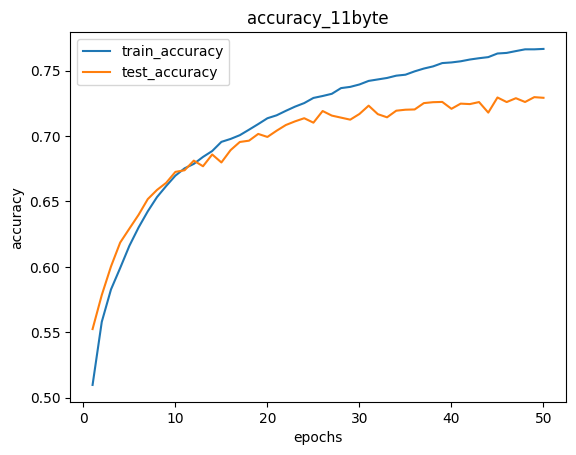

In [275]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [276]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 517us/step


(1000, 9)

In [277]:
attack_plain=data_attack['plain']

In [278]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [279]:
attack_sbox_out_hw.shape

(256, 1000)

In [280]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

28
33
7
3
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


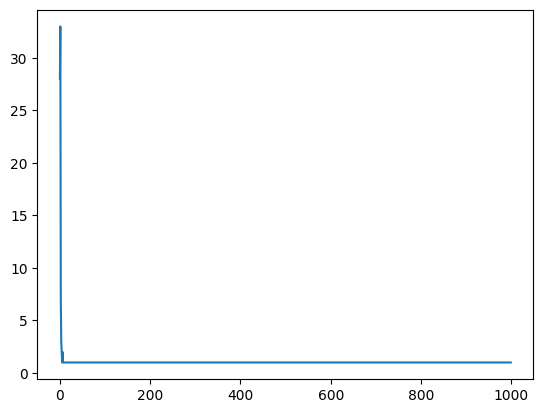

In [281]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

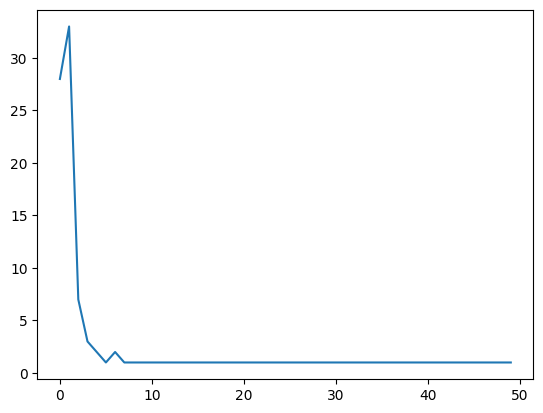

In [282]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [283]:
recovered_key11=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count11 = 1
        else:
            count11 = 0
        
        recovered_key11.append(count11) #攻撃成功バイト数の保存

recovered_key11 = np.array(recovered_key11)
np.save('./'+out+'/test11.npy', recovered_key11)

In [284]:
TARGET_BYTE = 12 #何バイト目を攻撃するか決める

In [285]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [286]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [287]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [288]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [289]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,350:400]
test_trace2 = test_trace[:,350:400]
attack_trace2 = attack_trace[:,350:400]
train_trace.shape

(80000, 1100)

In [290]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [291]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [292]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [293]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [294]:
print('train_trace shape:{}'.format(train_trace.shape))
print('train_sbox_out_hw shape:{}'.format(train_sbox_out_hw.shape))
print('test_trace shape:{}'.format(test_trace.shape))
print('test_sbox_out_hw shape:{}'.format(test_sbox_out_hw.shape))
print('attack_trace shape:{}'.format(attack_trace.shape))

print('train_trace type:{}'.format(type(train_trace)))
print('train_sbox_out_hw type:{}'.format(type(train_sbox_out_hw)))
print('test_trace type:{}'.format(type(test_trace)))
print('test_sbox_out_hw type:{}'.format(type(test_sbox_out_hw)))
print('attack_trace type:{}'.format(type(attack_trace)))

train_trace shape:(80000, 1100)
train_sbox_out_hw shape:(80000,)
test_trace shape:(20000, 1100)
test_sbox_out_hw shape:(20000,)
attack_trace shape:(1000, 1100)
train_trace type:<class 'numpy.ndarray'>
train_sbox_out_hw type:<class 'numpy.ndarray'>
test_trace type:<class 'numpy.ndarray'>
test_sbox_out_hw type:<class 'numpy.ndarray'>
attack_trace type:<class 'numpy.ndarray'>


In [295]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [296]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [297]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 4s 5ms/step - loss: 1.4142 - accuracy: 0.3963 - val_loss: 1.3163 - val_accuracy: 0.4284
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 1.2848 - accuracy: 0.4397 - val_loss: 1.2243 - val_accuracy: 0.4666
Epoch 3/50
625/625 [==============================] - 4s 7ms/step - loss: 1.1868 - accuracy: 0.4790 - val_loss: 1.1393 - val_accuracy: 0.4988
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 1.1113 - accuracy: 0.5131 - val_loss: 1.0692 - val_accuracy: 0.5280
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0553 - accuracy: 0.5355 - val_loss: 1.0362 - val_accuracy: 0.5401
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0146 - accuracy: 0.5555 - val_loss: 0.9996 - val_accuracy: 0.5544
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9834 - accuracy: 0.5675 - val_loss: 0.9791 - val_accuracy: 0.5660
Epoch 

In [298]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

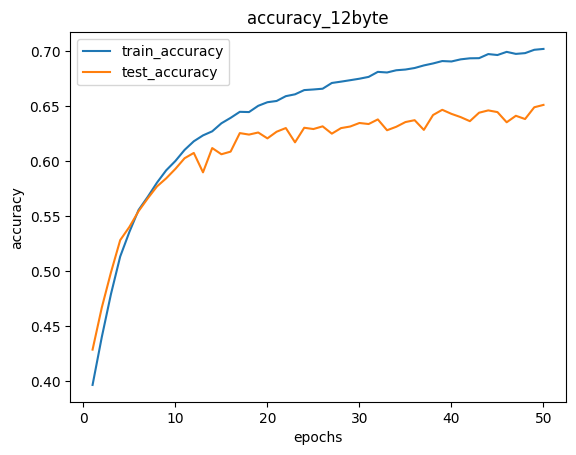

In [299]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [300]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 527us/step


(1000, 9)

In [301]:
attack_plain=data_attack['plain']

In [302]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [303]:
attack_sbox_out_hw.shape

(256, 1000)

In [304]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

84
40
11
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

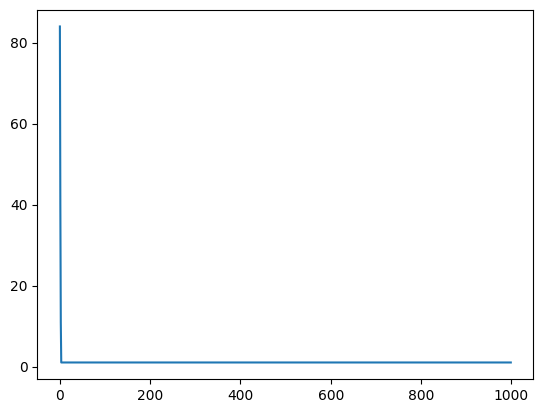

In [305]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

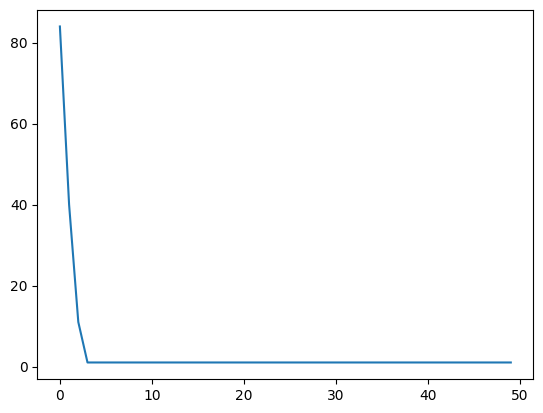

In [306]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [307]:
recovered_key12=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count12 = 1
        else:
            count12 = 0
        
        recovered_key12.append(count12) #攻撃成功バイト数の保存

recovered_key12 = np.array(recovered_key12)
np.save('./'+out+'/test12.npy', recovered_key12)

In [308]:
TARGET_BYTE = 13 #何バイト目を攻撃するか決める

In [309]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [310]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [311]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [312]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [313]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,590:640]
test_trace2 = test_trace[:,590:640]
attack_trace2 = attack_trace[:,590:640]
train_trace.shape

(80000, 1100)

In [314]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [315]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [316]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [317]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [318]:
print('train_trace shape:{}'.format(train_trace.shape))
print('train_sbox_out_hw shape:{}'.format(train_sbox_out_hw.shape))
print('test_trace shape:{}'.format(test_trace.shape))
print('test_sbox_out_hw shape:{}'.format(test_sbox_out_hw.shape))
print('attack_trace shape:{}'.format(attack_trace.shape))

print('train_trace type:{}'.format(type(train_trace)))
print('train_sbox_out_hw type:{}'.format(type(train_sbox_out_hw)))
print('test_trace type:{}'.format(type(test_trace)))
print('test_sbox_out_hw type:{}'.format(type(test_sbox_out_hw)))
print('attack_trace type:{}'.format(type(attack_trace)))

train_trace shape:(80000, 1100)
train_sbox_out_hw shape:(80000,)
test_trace shape:(20000, 1100)
test_sbox_out_hw shape:(20000,)
attack_trace shape:(1000, 1100)
train_trace type:<class 'numpy.ndarray'>
train_sbox_out_hw type:<class 'numpy.ndarray'>
test_trace type:<class 'numpy.ndarray'>
test_sbox_out_hw type:<class 'numpy.ndarray'>
attack_trace type:<class 'numpy.ndarray'>


In [319]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [320]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [321]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 4s 5ms/step - loss: 1.2223 - accuracy: 0.4615 - val_loss: 1.1023 - val_accuracy: 0.5034
Epoch 2/50
625/625 [==============================] - 4s 7ms/step - loss: 1.1049 - accuracy: 0.4999 - val_loss: 1.0701 - val_accuracy: 0.5084
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0771 - accuracy: 0.5099 - val_loss: 1.0423 - val_accuracy: 0.5281
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 1.0514 - accuracy: 0.5207 - val_loss: 1.0177 - val_accuracy: 0.5411
Epoch 5/50
625/625 [==============================] - 4s 7ms/step - loss: 1.0239 - accuracy: 0.5352 - val_loss: 0.9887 - val_accuracy: 0.5597
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9941 - accuracy: 0.5500 - val_loss: 0.9525 - val_accuracy: 0.5748
Epoch 7/50
625/625 [==============================] - 3s 5ms/step - loss: 0.9667 - accuracy: 0.5649 - val_loss: 0.9412 - val_accuracy: 0.5790
Epoch 

In [322]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

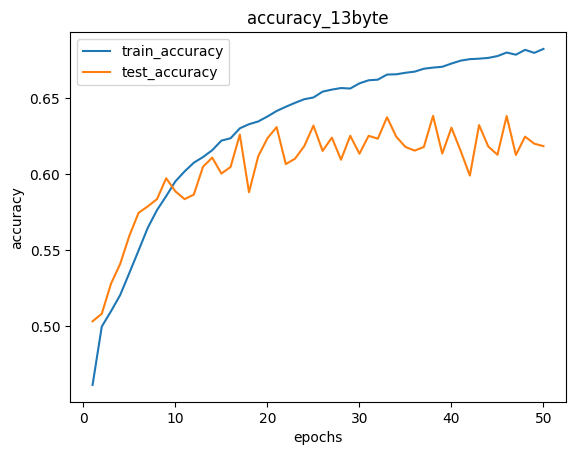

In [323]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [324]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 737us/step


(1000, 9)

In [325]:
attack_plain=data_attack['plain']

In [326]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [327]:
attack_sbox_out_hw.shape

(256, 1000)

In [328]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

126
83
16
4
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


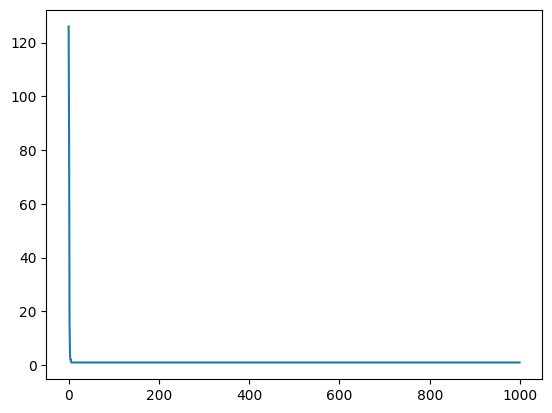

In [329]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

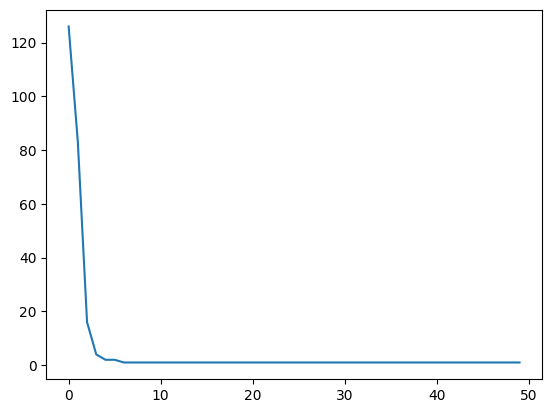

In [330]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [331]:
recovered_key13=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count13 = 1
        else:
            count13 = 0
        
        recovered_key13.append(count13) #攻撃成功バイト数の保存

recovered_key13 = np.array(recovered_key13)
np.save('./'+out+'/test13.npy', recovered_key13)

In [332]:
TARGET_BYTE = 14 #何バイト目を攻撃するか決める

In [333]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [334]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [335]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [336]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [337]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,840:890]
test_trace2 = test_trace[:,840:890]
attack_trace2 = attack_trace[:,840:890]
train_trace.shape

(80000, 1100)

In [338]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [339]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [340]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [341]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [342]:
print('train_trace shape:{}'.format(train_trace.shape))
print('train_sbox_out_hw shape:{}'.format(train_sbox_out_hw.shape))
print('test_trace shape:{}'.format(test_trace.shape))
print('test_sbox_out_hw shape:{}'.format(test_sbox_out_hw.shape))
print('attack_trace shape:{}'.format(attack_trace.shape))

print('train_trace type:{}'.format(type(train_trace)))
print('train_sbox_out_hw type:{}'.format(type(train_sbox_out_hw)))
print('test_trace type:{}'.format(type(test_trace)))
print('test_sbox_out_hw type:{}'.format(type(test_sbox_out_hw)))
print('attack_trace type:{}'.format(type(attack_trace)))

train_trace shape:(80000, 1100)
train_sbox_out_hw shape:(80000,)
test_trace shape:(20000, 1100)
test_sbox_out_hw shape:(20000,)
attack_trace shape:(1000, 1100)
train_trace type:<class 'numpy.ndarray'>
train_sbox_out_hw type:<class 'numpy.ndarray'>
test_trace type:<class 'numpy.ndarray'>
test_sbox_out_hw type:<class 'numpy.ndarray'>
attack_trace type:<class 'numpy.ndarray'>


In [343]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [344]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [345]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 5s 6ms/step - loss: 1.2188 - accuracy: 0.4717 - val_loss: 1.0953 - val_accuracy: 0.5146
Epoch 2/50
625/625 [==============================] - 4s 7ms/step - loss: 1.0757 - accuracy: 0.5271 - val_loss: 1.0322 - val_accuracy: 0.5459
Epoch 3/50
625/625 [==============================] - 3s 6ms/step - loss: 1.0187 - accuracy: 0.5538 - val_loss: 0.9731 - val_accuracy: 0.5669
Epoch 4/50
625/625 [==============================] - 4s 7ms/step - loss: 0.9761 - accuracy: 0.5760 - val_loss: 0.9428 - val_accuracy: 0.5829
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9410 - accuracy: 0.5929 - val_loss: 0.9101 - val_accuracy: 0.6035
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.9092 - accuracy: 0.6080 - val_loss: 0.8875 - val_accuracy: 0.6107
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 0.8814 - accuracy: 0.6208 - val_loss: 0.8608 - val_accuracy: 0.6270
Epoch 

In [346]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

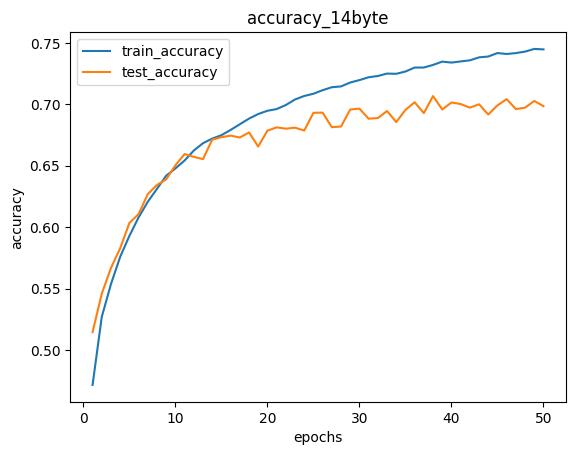

In [347]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [348]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 573us/step


(1000, 9)

In [349]:
attack_plain=data_attack['plain']

In [350]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [351]:
attack_sbox_out_hw.shape

(256, 1000)

In [352]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

28
5
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

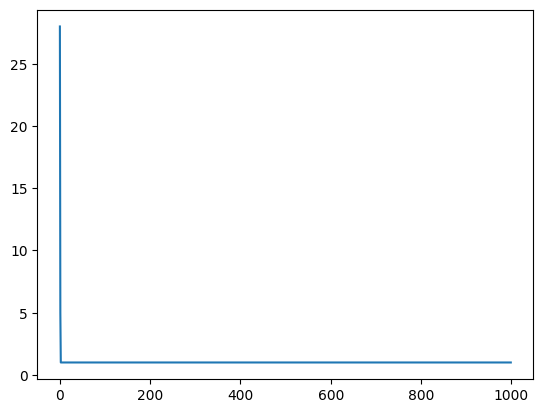

In [353]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

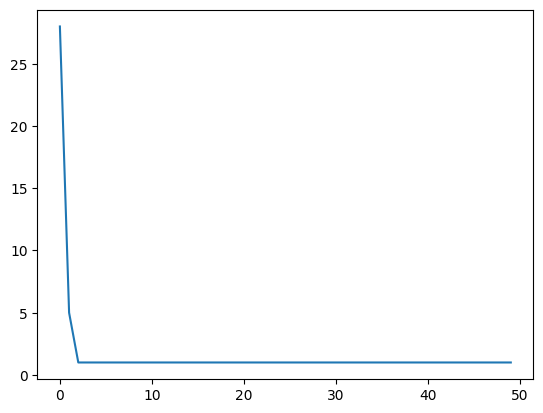

In [354]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [355]:
recovered_key14=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count14 = 1
        else:
            count14 = 0
        
        recovered_key14.append(count14) #攻撃成功バイト数の保存

recovered_key14 = np.array(recovered_key14)
np.save('./'+out+'/test14.npy', recovered_key14)

In [356]:
TARGET_BYTE = 15 #何バイト目を攻撃するか決める

In [357]:
AES_Sbox = np.array([
			0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
			0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
			0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
			0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
			0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
			0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
			0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
			0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
			0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
			0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
			0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
			0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
			0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
			0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
			0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
			0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
			])

In [358]:
#HW表の導出
hw = []
for i in range(256): #HW表は256通りの入力
    v = 0
    for b in range(8): v += (i >> b) & 0x01 #最下位ビットの値を足して、1bitシフト ← これを8回繰り返して、HWを求める
    hw.append(v)
hw = np.array(hw)

In [359]:
data_train = np.load('./datadlsca/8bit_AES_data2.npz')
data_test = np.load('./datadlsca/8bit_AES_data2.npz')
data_attack = np.load('./data/8bit_AES_data.npz')

In [360]:
train_plain = data_train['plain']
train_cipher = data_train['cipher']
train_key = data_train['key']
train_trace = data_train['trace']

test_plain = data_test['plain']
test_cipher = data_test['cipher']
test_key = data_test['key']
test_trace = data_test['trace']

attack_plain = data_attack['plain']
attack_cipher = data_attack['cipher']
attack_key = data_attack['key']
attack_trace = data_attack['trace']
train_key.shape

(16,)

In [361]:
train_trace = train_trace[0:80000, 1700:2800]
test_trace = test_trace[80000:100000,1700:2800]
attack_trace = attack_trace[:,1700:2800]
train_plain = train_plain[0:80000, :]
test_plain = test_plain[80000:100000, :]
train_trace2 = train_trace[:,1050:1100]
test_trace2 = test_trace[:,1050:1100]
attack_trace2 = attack_trace[:,1050:1100]
train_trace.shape

(80000, 1100)

In [362]:
train_sbox_in = []
train_sbox_in = np.array(train_plain^train_key) #平文と鍵のXORがSbox(SubBytes)入力
train_sbox_out = np.array([AES_Sbox[i] for i in train_sbox_in])
train_sbox_out_hw = np.array([hw[i] for i in train_sbox_out])
train_sbox_out_hw.shape

(80000, 16)

In [363]:
test_sbox_in = []
test_sbox_in = np.array(test_plain^np.array(test_key)) #平文と鍵のXORがSbox(SubBytes)入力
test_sbox_out = np.array([AES_Sbox[i] for i in test_sbox_in])
test_sbox_out_hw = np.array([hw[i] for i in test_sbox_out])
test_sbox_out_hw.shape

(20000, 16)

In [364]:
train_sbox_out_hw = train_sbox_out_hw[:,TARGET_BYTE]
test_sbox_out_hw = test_sbox_out_hw[:,TARGET_BYTE]

In [365]:
#波形データの標準化(データを平均で引いて標準偏差で割る)
train_trace2 = (train_trace2 -np.mean(train_trace2, axis = 0))/np.std(train_trace2, axis = 0)

test_trace2 = (test_trace2 - np.mean(test_trace2, axis = 0))/np.std(test_trace2, axis = 0)

attack_trace2 = (attack_trace2 - np.mean(attack_trace2, axis = 0))/np.std(attack_trace2, axis = 0)

#DeepLearningできるshapeに変更
train_trace2 = train_trace2.reshape(80000,50,1)

test_trace2 = test_trace2.reshape(20000,50,1)

attack_trace2 = attack_trace2.reshape(1000,50,1)

In [366]:
print('train_trace shape:{}'.format(train_trace.shape))
print('train_sbox_out_hw shape:{}'.format(train_sbox_out_hw.shape))
print('test_trace shape:{}'.format(test_trace.shape))
print('test_sbox_out_hw shape:{}'.format(test_sbox_out_hw.shape))
print('attack_trace shape:{}'.format(attack_trace.shape))

print('train_trace type:{}'.format(type(train_trace)))
print('train_sbox_out_hw type:{}'.format(type(train_sbox_out_hw)))
print('test_trace type:{}'.format(type(test_trace)))
print('test_sbox_out_hw type:{}'.format(type(test_sbox_out_hw)))
print('attack_trace type:{}'.format(type(attack_trace)))

train_trace shape:(80000, 1100)
train_sbox_out_hw shape:(80000,)
test_trace shape:(20000, 1100)
test_sbox_out_hw shape:(20000,)
attack_trace shape:(1000, 1100)
train_trace type:<class 'numpy.ndarray'>
train_sbox_out_hw type:<class 'numpy.ndarray'>
test_trace type:<class 'numpy.ndarray'>
test_sbox_out_hw type:<class 'numpy.ndarray'>
attack_trace type:<class 'numpy.ndarray'>


In [367]:
class DLSCA(keras.Model):
    def __init__(self):
        super(DLSCA, self).__init__()
        self.conv = L.Conv1D(filters=10, kernel_size=3,strides=3, activation='relu',input_shape=(1000,1)) 
        self.flatten = L.Flatten()
        self.d1 = L.Dense(64, activation='tanh')
        self.d2 = L.Dense(64, activation='tanh')
        self.d3 = L.Dense(9, activation='softmax')
    def call(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return self.d3(x)

In [368]:
model=DLSCA()
model.compile(optimizer="adam",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])

In [369]:
epochs=50
learning_data = model.fit(train_trace2,train_sbox_out_hw,epochs=epochs,batch_size=128,validation_data=(test_trace2,test_sbox_out_hw))

Epoch 1/50
625/625 [==============================] - 5s 6ms/step - loss: 1.5446 - accuracy: 0.3578 - val_loss: 1.4744 - val_accuracy: 0.3769
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 1.4415 - accuracy: 0.3942 - val_loss: 1.4283 - val_accuracy: 0.3930
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 1.3966 - accuracy: 0.4169 - val_loss: 1.3781 - val_accuracy: 0.4205
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 1.3537 - accuracy: 0.4368 - val_loss: 1.3381 - val_accuracy: 0.4405
Epoch 5/50
625/625 [==============================] - 4s 7ms/step - loss: 1.3151 - accuracy: 0.4560 - val_loss: 1.3010 - val_accuracy: 0.4573
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 1.2806 - accuracy: 0.4748 - val_loss: 1.2712 - val_accuracy: 0.4703
Epoch 7/50
625/625 [==============================] - 4s 7ms/step - loss: 1.2494 - accuracy: 0.4889 - val_loss: 1.2406 - val_accuracy: 0.4902
Epoch 

In [370]:
out = 'result'
os.makedirs(os.path.join('./', out), exist_ok=True)
model.save_weights(os.path.join('./',out,'compare_attack_{}byte.h5').format(TARGET_BYTE))

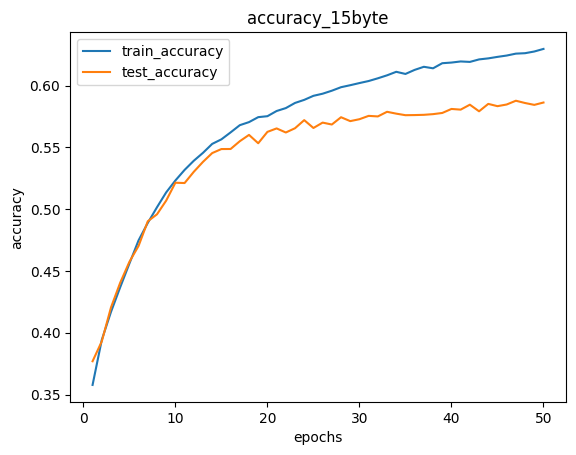

In [371]:
plt.figure()
plt.subplot(1,1,1)
plt.plot(range(1,epochs+1), learning_data.history['accuracy'], label = 'train_accuracy')
plt.plot(range(1,epochs+1), learning_data.history['val_accuracy'], label = 'test_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('accuracy_{}byte'.format(TARGET_BYTE))
plt.legend()
plt.savefig('./'+out+'/compare_accuracy_{}byte.png'.format(TARGET_BYTE))

In [372]:
predicts = model.predict(attack_trace2)
predicts.shape

32/32 [==============================] - 0s 494us/step


(1000, 9)

In [373]:
attack_plain=data_attack['plain']

In [374]:
attack_sbox_in = []
for estimated_key in range(256): #256通りの推定鍵だけ繰り返す。
    attack_sbox_in.append(attack_plain^np.array([estimated_key]*16)) #平文と推定鍵のXORがSbox(SubBytes)入力
attack_sbox_in = np.array(attack_sbox_in)
attack_sbox_out = np.array([AES_Sbox[i] for i in attack_sbox_in])
attack_sbox_out_hw = np.array([hw[i] for i in attack_sbox_out])
attack_sbox_out_hw = attack_sbox_out_hw[:,:,TARGET_BYTE]

In [375]:
attack_sbox_out_hw.shape

(256, 1000)

In [376]:
result=[]
rank=[]

for i in range(len(predicts)):
    rank_num = 0
    yuudo = []
    for estimated_key in range(256):
        yuudo.append(predicts[i,attack_sbox_out_hw[estimated_key,i]])
    yuudo = np.array(yuudo)
    
    if i==0:
        result = (1/256) * yuudo
        result = result/np.sum(result)

    else:
        result = result * yuudo
        result = result/np.sum(result)
    
    for estimated_key in range(256):
        if result[attack_key[TARGET_BYTE]]<=result[estimated_key]:
            rank_num = rank_num + 1
    rank.append(rank_num)
    print(rank[i])

rank=np.array(rank)

64
12
3
13
7
3
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1

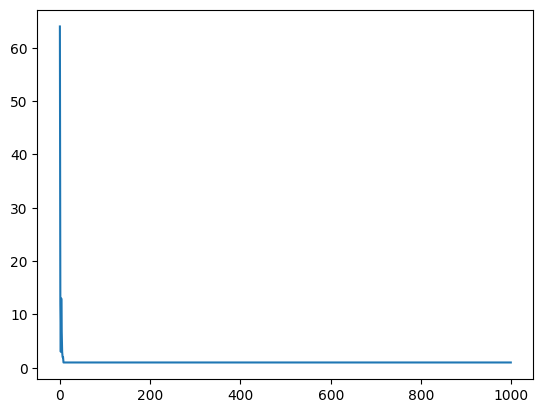

In [377]:
rank_lim = rank[0:1000]
plt.plot(rank_lim)

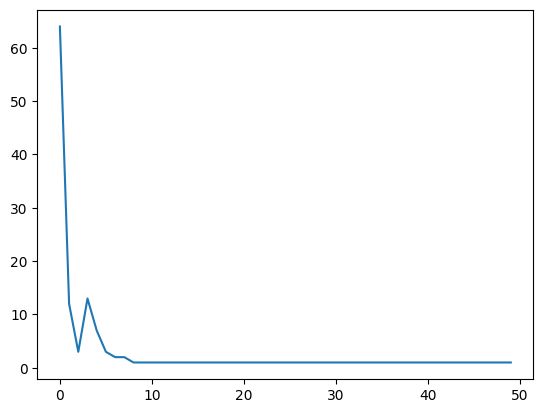

In [378]:
rank_lim = rank[0:50]
plt.plot(rank_lim)

In [379]:
recovered_key15=[]

for i in range(50):
        if rank_lim[i] == 1: #推定した鍵と正解鍵が一致しているかを確認
            count15 = 1
        else:
            count15 = 0
        
        recovered_key15.append(count15) #攻撃成功バイト数の保存

recovered_key15 = np.array(recovered_key15)
np.save('./'+out+'/test15.npy', recovered_key15)

Text(0, 0.5, 'recovered_key')

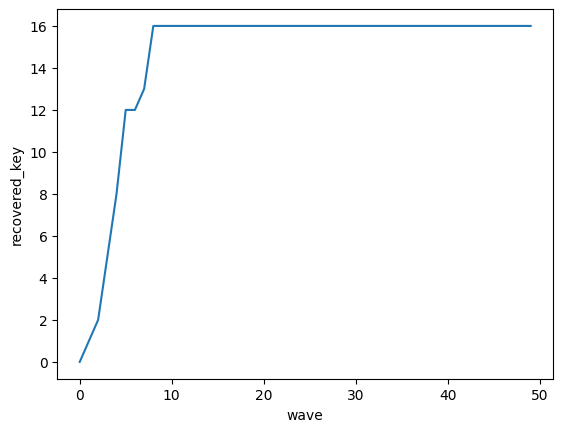

In [380]:
A = recovered_key0 + recovered_key1 + recovered_key2 + recovered_key3 + recovered_key4 + recovered_key5 + recovered_key6 + recovered_key7 + recovered_key8 + recovered_key9 + recovered_key10 + recovered_key11 + recovered_key12 + recovered_key13 + recovered_key14 + recovered_key15
plt.plot(A)
plt.xlabel('wave')
plt.ylabel('recovered_key')